# Where should I move?
One of the biggest factors in deciding where to move is the temperature. This notebook imports historical temperature data for selected locations and charts them together. I can compare the historical average temperature (in farenheit) of where I live now to where I might move. Soon, I will add predictions, to see how hot it might be in the future.

## import packages

In [22]:
# ! pip install --upgrade pip

# ! pip install pandas
# ! pip install numpy
# ! pip install plotly
# ! pip install scikit-learn
# ! pip install prophet
# ! pip install ipywidgets
# # ! pip install hvplot datashader holoviews panel param colorcet
# ! pip install meteostat
# ! pip install requests
# ! pip install geopy


## documentation

In [23]:
# https://dev.meteostat.net/python/stations.html#example
# https://dev.meteostat.net/python/normals.html#data-structure
# https://www.geeksforgeeks.org/python-requests-tutorial/
# https://www.askpython.com/python/examples/weather-forecast-using-python
# https://www.askpython.com/python/examples/technical-analysis-basics
# https://facebook.github.io/prophet/docs/quick_start.html

In [48]:
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.io as pio
import sklearn as sk
from collections import defaultdict
import meteostat
import prophet
import math
import requests

from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error

# Import Meteostat library and dependencies
from datetime import datetime, date
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Monthly, Normals
from functools import reduce

## functions

In [25]:
# function: convert to farenheit

def farenheit(c):
    f = (c * 1.8) + 32
    return f

## blog example - prophet

In [26]:
# Set time period
start3 = datetime(2021, 1, 1)
end3 = datetime(2022, 9, 30)

# Create Point for Bangalore, KARNATAKA
place3 = Point(12.971599, 77.594566)
data3 = Daily(place3, start3, end3)
data3 = data3.fetch()

In [27]:
# The input to Prophet is always a dataframe with two columns: ds and y. 
# The ds (datestamp) column should be of a format expected by Pandas, ideally 
# YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. 
# The y column must be numeric, and represents the measurement we wish to forecast.

In [28]:
train = data3.loc[:'2022-08-31']
test = data3.loc['2022-09-01':]

train = data3[['tavg']].reset_index()
train.columns = ['ds', 'y']

In [29]:
m = Prophet()
m.fit(train)

future = pd.DataFrame(test.index.values)
future.columns = ['ds']

forecast = m.predict(future) 

19:24:36 - cmdstanpy - INFO - Chain [1] start processing
19:24:36 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# calculate MAE between expected and predicted values
y_true = test['tavg'].values
y_pred = forecast['yhat'].values

rmse = math.sqrt(mean_absolute_error(y_true, y_pred))
print('RMSE:', rmse)

RMSE: 0.8924285893828552


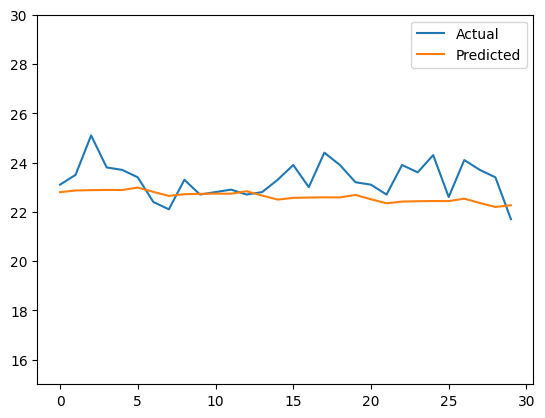

In [31]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.ylim(ymax=30, ymin=15)
plt.legend()
plt.show()

In [32]:
# Note that the forecasting model we created here is a very simple model. 
# The model can be further improved based on domain knowledge and trying different 
# models such as ARIMA, SARIMA, SARIMAX, etc. 

# places

In [49]:
# points for places (lat, long)

salem = Point(44.942898, -123.035095)
aberdeen = Point(46.975460, -123.815529)
rapidcity = Point(44.082989, -103.224457)
alameda = Point(37.765340, -122.241870)
hawthornwoods = Point(40.741895, -73.989308)


In [50]:
places = [salem, aberdeen, rapidcity, alameda]
names = ['salem', 'aberdeen', 'rapidcity', 'alameda']

## get temperature averages for selected places

In [35]:
# Set time period
start = datetime(2020, 1, 1)
end = datetime.today()

placelen = range(len(places))

places_list = []
yaxis_names = []

for p in placelen:
    placename = names[p]
    d = Daily(places[p], start, end)
    d_data_avg  = d.fetch()[['tavg']].reset_index()
    d_data_avg.columns = ['time_index', f"{placename}_tavg"]
    places_list.append(d_data_avg)
    yaxis_names.append(f"{placename}_tavg")

places_df = reduce(lambda left, right: pd.merge(left,right,on=['time_index'], how='outer'), places_list).fillna(0)


## convert to farenheit

In [36]:
cels = places_df.select_dtypes(include=['float64']).columns.tolist()
places_df[cels] = places_df[cels].apply(lambda x : farenheit(x))

## plot

In [42]:
# using plotly
fig = px.line(places_df, x="time_index", y=yaxis_names, title="historical average temperatures", template='ggplot2')

fig.update_layout(xaxis_title="date", yaxis_title="Avg Temp (f)")

plotly.offline.plot(fig, filename='historical_temps.html')
fig.show()

## get average precipitation

In [40]:
# Set time period
start = datetime(2020, 1, 1)
end = datetime.today()

placelen = range(len(places))

rain_list = []
rain_yaxis_names = []

for p in placelen:
    placename = names[p]
    d = Daily(places[p], start, end)
    d_data_avg  = d.fetch()[['prcp']].reset_index()
    d_data_avg.columns = ['time_index', f"{placename}_prcp"]
    rain_list.append(d_data_avg)
    rain_yaxis_names.append(f"{placename}_prcp")

rain_places_df = reduce(lambda left, right: pd.merge(left,right,on=['time_index'], how='outer'), rain_list).fillna(0)


## plot

In [43]:
# using plotly
fig = px.line(rain_places_df, x="time_index", y=rain_yaxis_names, title="historical average rainfall", template='simple_white')

fig.update_layout(xaxis_title="date", yaxis_title="Avg Rain")

plotly.offline.plot(fig, filename='historical_rain.html')
fig.show()

# wttr.in

In [7]:
print("\t\tWelcome to the Weather Forecaster!\n\n")
print("Just Enter the City you want the weather report for and click on the button! It's that simple!\n\n")
 
city_name = input("Enter the name of the City : ")
print("\n\n")
 
# Function to Generate Report
def Gen_report(C):
    url = 'https://wttr.in/{}'.format(C)
    try:
        data = requests.get(url)
        T = data.text
    except:
        T = "Error Occurred"
    print(T)
     
Gen_report(city_name)

		Welcome to the Weather Forecaster!


Just Enter the City you want the weather report for and click on the button! It's that simple!





Weather report: Seattle

      \   /     Sunny
       .-.      87 °F          
    ― (   ) ―   → 3 mph        
       `-’      6 mi           
      /   \     0.0 in         
                                                       ┌─────────────┐                                                       
┌──────────────────────────────┬───────────────────────┤  Fri 09 Aug ├───────────────────────┬──────────────────────────────┐
│            Morning           │             Noon      └──────┬──────┘     Evening           │             Night            │
├──────────────────────────────┼──────────────────────────────┼──────────────────────────────┼──────────────────────────────┤
│     \   /     Sunny          │     \   /     Sunny          │     \   /     Sunny          │     \   /     Clear          │
│      .-.      +73(75) °F     │      .-.      84 °F    